In [1]:
import keras
import h5py
import cv2
import os
os.environ['KERAS_BACKEND']='tensorflow'
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.datasets import mnist
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Input, Dense, Convolution2D, Conv2DTranspose, Dropout
from keras.layers import MaxPooling2D, UpSampling2D
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
print('libs loaded')

/home/ian/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


libs loaded


In [2]:
# perameters

size = 256

(341, 256, 256, 1)
(341, 256, 256, 1)


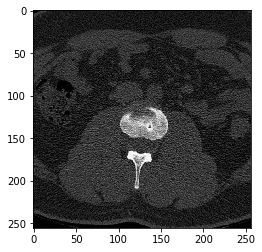

In [3]:
def load_data():
    filenames = []
    for root, dirs, files in os.walk('./data/x'):
        for name in files:
            filenames.append(os.path.join(root, name).split('/')[-1])

    num = len(filenames)
    size = 256
    data_shape = (num, size, size)
    X = np.zeros(data_shape)
    Y = np.zeros(data_shape)
    
    for i in range(num):
        f = filenames[i]
        img = np.array(cv2.imread('./data/x/' + f, 0))
        img2 = np.array(cv2.imread('./data/y/' + f, 0))
        X[i, :, :] = img
        Y[i, :, :] = img2
    
    X = X.reshape(num, size, size, 1)
    Y = Y.reshape(num, size, size, 1)
    
    X = X.astype('float32')
    Y = Y.astype('float32')
    
    X /= 255
    Y /= 255
    
    print(X.shape)
    
    return X, Y

X_train, Y_train = load_data()
print(X_train.shape)
plt.imshow(X_train[0,:,:,0], cmap='gray')

In [4]:
model = Sequential()

# encoder
model.add(Convolution2D(32, (3, 3), padding='same', activation='relu', input_shape=(size,size,1)))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))


# (None, 7, 7, 32)

# decoder
model.add(Conv2DTranspose(32, (3, 3), padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2DTranspose(32, (3, 3), padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))

model.add(Conv2DTranspose(1, (3, 3), padding='same', activation='relu'))

print (model.output_shape)

opt = keras.optimizers.Adam(lr=0.001)

model.compile(optimizer=opt,
              loss='mse',
              metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_grads=True, write_images=True)

(None, 256, 256, 1)


In [5]:
# training
model.fit(X_train, Y_train,
                epochs=10,
                batch_size=50,
                shuffle=True,
                callbacks=[tensorboard])

"""
Epoch 20/20
60000/60000 [==============================] - 7s - loss: 0.0398
"""


Epoch 1/10
341/341 [==============================] - 2s 6ms/step - loss: 0.0597 - acc: 0.9117
Epoch 2/10
341/341 [==============================] - 1s 3ms/step - loss: 0.0468 - acc: 0.9117
Epoch 3/10
341/341 [==============================] - 1s 3ms/step - loss: 0.0355 - acc: 0.9203
Epoch 4/10
341/341 [==============================] - 1s 3ms/step - loss: 0.0192 - acc: 0.9420
Epoch 5/10
341/341 [==============================] - 1s 2ms/step - loss: 0.0148 - acc: 0.9437
Epoch 6/10
341/341 [==============================] - 1s 2ms/step - loss: 0.0134 - acc: 0.9454
Epoch 7/10
341/341 [==============================] - 1s 2ms/step - loss: 0.0117 - acc: 0.9490
Epoch 8/10
341/341 [==============================] - 1s 2ms/step - loss: 0.0103 - acc: 0.9515
Epoch 9/10
341/341 [==============================] - 1s 2ms/step - loss: 0.0091 - acc: 0.9530
Epoch 10/10
341/341 [==============================] - 1s 2ms/step - loss: 0.0085 - acc: 0.9534


'\nEpoch 20/20\n60000/60000 [==============================] - 7s - loss: 0.0398\n'

In [6]:
# save
model.save('model.h5')   # HDF5 file, you have to pip3 install h5py if don't have it
del model  # deletes the existing model


(1, 256, 256, 1)


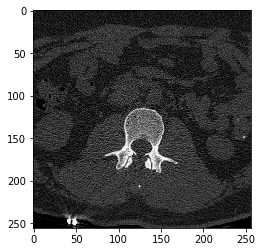

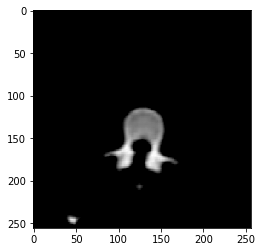

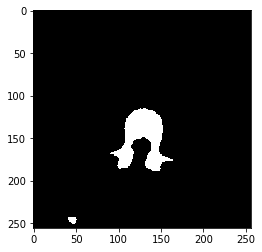

In [13]:
# load
model = load_model('model.h5')
num = 10
X = X_train[num:num+1]
img = model.predict(X)
img2 = img > 0.5
print(img.shape)

plt.imshow(X.reshape(size,size), cmap='gray')
plt.show()
plt.imshow(img.reshape(size,size), cmap='gray')
plt.show()
plt.imshow(img2.reshape(size,size), cmap='gray')
plt.show()